# (E03)3rd_project-Camera_sticker_application
************************************************************************************************************

## 1. 얼굴 인식 모델 적용시키기

      이번 과정에서 얼굴을 찾는 모델은 공개된 패키지를 이용하여 진행한다. dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다.

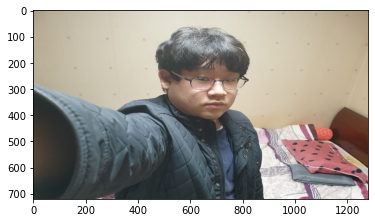

(716, 315)
(x,y) : (716,203)
(w,h) : (224,224)


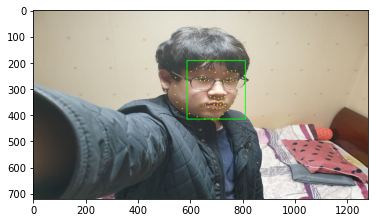

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import os
from PIL import Image

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (1280, 720))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR이미지 색배치를 RGB로 바꿔줌
plt.imshow(img_rgb)
plt.show()

detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img_rgb, 1)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 얼굴 인식

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]- dlib_rect.width()//2 #(x,y)가 나타내는 곳은 사각형 윗변의 이등분점
    w = dlib_rect.width() # 사각형의 가로 크기
    h = dlib_rect.width() # 사각형의 세로 크기
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show() # 인식된 얼굴 사각형 확인

      약간 얼굴이 옆으로 돌아간 사진임에도 얼굴 외곽이 잘 인식되고 있다. 특히 사격형 범위도 얼굴 전체를 나타내는 것이 아니라 코를 중심으로 정사각형을 표시하고 있다. 
  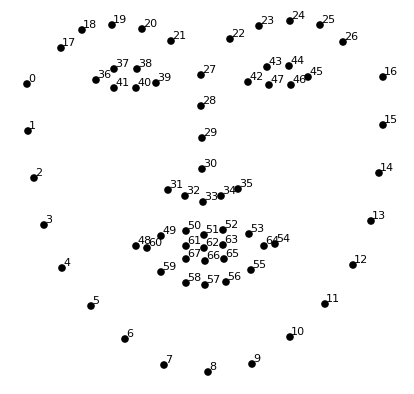

    해당 점들의 위치는 위 첨부된 사진에서 확인 할 수 있다.

## 2. 고양이 수염 붙이기

      고양이 수염 이미지를 불러와서 인식된 얼굴에 합성하는 과정이다. 여러가지 위치를 적용 시켜봤을 때, 가장 어색하지 않았던 곳은 landmark[30] 이였으므로 해당 좌표를 기준으로 합성하곘다.

In [2]:
#고양이 수염 붙이기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

refined_x = x - w // 2  # left
refined_y = y    # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) # (refined_x, refined_y)가 나타내는 좌표는 사각형의 윗변 왼쪽의 점

if refined_y<0 :  # refined_y가 그림 위로 넘어갈 경우 예외처리
    img_sticker = img_sticker[-refined_y:] # 음수 부분 잘라내고
    refined_y = 0 # refined_y를 0으로 리턴
    
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) # (refined_x, refined_y) 수정된 좌표값

(224, 224, 3)
(x,y) : (604,203)
(x,y) : (604,203)


      합성할 고양이 수염 이미지의 크기를 확인하고 얼굴이 인식된 범위에 맞게 리사이즈 해준다. 합성 될 범위의 시작 좌표값 (refined_x, refined_y)를 구해주고 해당 값들이 음수라면 음수 범위는 제거해 주는 과정이 필요하다. 여기서는 사각형 안쪽으로만 들어가기 때문에 필요없지만 일단 작성은 해둔다. 만약 합성 범위가 주어진 사진 밖 상하좌우로 나가는 경우엔 이러한 과정을 거쳐줘야한다. 이경우 사진의 크기인 1024X720을 벗어나는 위치에 합성될 경우다.

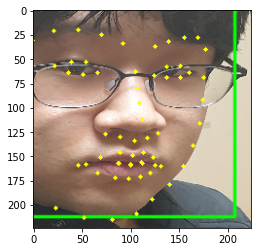

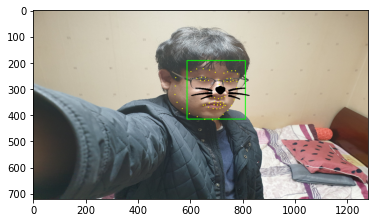

In [3]:
img_show_cat_whiskers = img_show.copy()

sticker_area = img_show_cat_whiskers[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] #잘라낼 이미지 범위 설정, 주의사항은 (y범위 , x범위)임

plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))
plt.show() #잘라낸 사진 확인

img_show_cat_whiskers[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8) #붙일 사진의 해당 픽셀 값이 0이면 붙이고 아니면 원래대로 둠

plt.imshow(cv2.cvtColor(img_show_cat_whiskers, cv2.COLOR_BGR2RGB))
plt.show() # 합성된 사진 확인

      위 과정에서 몇 가지 어려움이 있었다. 첫번째는 고양이 수염 이미지가 수염 부분은 투명해지고 나머지가 흰색으로 합성되는 것이였고 두번째는 합성이 진행되는 범위의 range가 맞지 않아서 컴파일 에러가 발생하는 것이였다
      첫번째 문제는 np.where()의 자세한 정의를 보고나서 합성할 것과 그대로 둘것을 변경 해주니 간단하게 해결되었다.
      그러나 두번째 문제에서 꽤나 길게 골머리를 썩혔는데 주어진 예시에선 refined_y의 좌표가 무조건 음수로 간다고 가정하고 진행되었기 때문에 sticker_area를 설정할 때 코드가 필요한 부분이 제거되어서 올라와있었다. 각각의 크기를 확인하고 범위를 옳바르게 설정해주자 코드가 잘 진행되었다.

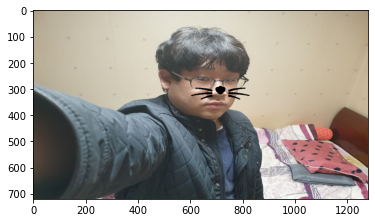

In [4]:
#위와 동일한 과정을 원본 이미지에서 수행
img_rgb_cat_whiskers = img_rgb.copy()

sticker_area = img_rgb_cat_whiskers[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_rgb_cat_whiskers[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(img_rgb_cat_whiskers)
plt.show()

      윗 과정에서 합성이 잘 진행된 것을 확인했으니 이제 원본 사진에 구한 좌표값으로 합성을 진행한다.
      확인해보면 역시 합성이 잘 진행된 것을 확인할 수 있다.

## 3. 스티커 뒤에 원본 사진 보이게 합성하기

      이번에는 예제에서 진행했던 머리 위에 왕관사진 올리기에서 한 단계 더 나아가 왕관을 반투명 하게 해서 원본 사진을 뒤에 비추게 해주는 것이 목표다. 스티커 사진이 합성될 좌표는 예제해서 진행했던 대로 진행해준다.

In [7]:
#반투명 왕관 머리에 올리기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print (img_sticker.shape)

refined_x = x - w // 2  # left
refined_y = y - h   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) # 이번에 붙일 위치(refined_x, refined_y)는 인식된 사각형 윗변 왼쪽 점에서부터 오른쪽 위로 붙임

if refined_y<0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0

print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) 

(224, 224, 3)
(x,y) : (604,-21)
(203, 224, 3)
(x,y) : (604,0)


      왕관이 들어갈 좌표를 계산 한 결과 refined_y의 값이 음수로 나와서 수정해 주는 과정이 진행되었다. 그 결과로 refined_y가 0으로 되고 합성될 사진이 잘려진 것을 확인 할 수 있다.

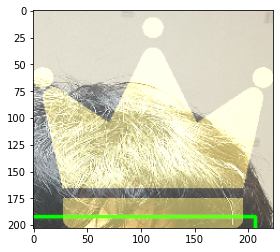

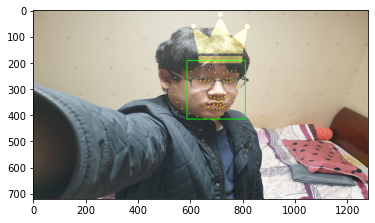

In [6]:
img_show_king = img_show.copy()
img_show_king = cv2.cvtColor(img_show_king, cv2.COLOR_BGR2RGB)

sticker_area = img_show_king[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] #잘라낼 위치 선정

dst = cv2.addWeighted(sticker_area, 1, img_sticker , 0.4, 0) #addWeighted함수를 이용하여 원본 사진에 붙일 사진을 반투명하게 합성해준다

plt.imshow(dst)
plt.show()

img_show_king[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = dst #잘라내고 합성 한 후 다시 붙여줌

plt.imshow(img_show_king)
plt.show()

      왕관이 들어갈 위치를 구하고 해당 부분을 sticker_area에 저장한다. 그리고 addWeighted 함수를 이용하여 스티커 이미지와 합성하는데 비중을 sticker_area를 1을 주고 스티커의 비중을 적당히 그 밑으로 주면 위의 진행된 사진처럼 스티커는 반투명해지고 뒤로 원본 사진이 비춰지는 것을 확인 할 수 있다.
      이 과정이 성공적으로 진행되었다면 다시 합성된 사진 dst를 본래 사진 위치에 넣어주면 합성이 완료된다.

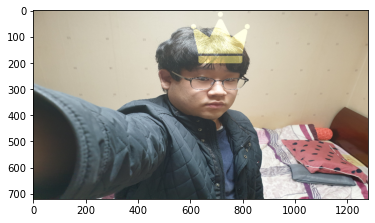

In [8]:
##위와 동일한 과정을 원본 이미지에서 수행
img_rgb_king = img_rgb.copy()

sticker_area = img_rgb_king[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

dst = cv2.addWeighted(sticker_area, 1, img_sticker , 0.4, 0)

img_rgb_king[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = dst

plt.imshow(img_rgb_king)
plt.show()

      위와 동일한 과정을 원본 사진에서 진행해본 결과 잘 진행됬음을 확인할 수 있다. 예제코드와 위에서 진행한 고양이 수염 합성하기를 이해했으면 생각보다 어렵지 않은 프로젝트였다.

## 4. 문제점 찾아보기

      해당 과정을 진행하면서 생길 수 있는 오류에 대해서 몇 가지 이야기해보자.
      
    1. 얼굴이 기울어져 있을 경우
    
          얼굴이 기울어져 있을 경우 인식은 제대로 되겠지만 얼굴과는 다르게 잡히는 사격형은 언제나 이미지와 평행한 변들을 가질 것이다. 그러면 얼굴은 기울어져 있는데 합성되는 사진은 똑바르게 있으니 어색할 겻이다. 이 경우 인식된 얼굴의 다른 여러 점들을 잡고 벡터의 기울기를 구해서 스티커 이미지를 마찬가지로 회전변환하여 합성을 진행해주면 될 것이다.
          
    2. 멀리서 촬영되있는 경우나 누워있는 경우
          
          멀리서 촬영되거나 누워있는 경우 인식이 아예 진행되지 않는다. 실제로 위의 사진을 세로로 저장하고 해당 코드를 돌려본 결과 사각형의 너비와 높이의 값인 w와 h값이 리턴되지 않는 걸 확인 할 수 있었다.
          전자의 경우는 인식되어야 할 얼굴이 너무 작아서 인식이 불가능한것이고 후자의 경우는 주어진 이미지가 기울어진 것을 넘어 아예 90도 회전 할 경우 얼굴로 인식을 하지 못하는 것 같다.
          
    3. 실행 속도
    
          실제로 이러한 이미지 합성 어플리케이션을 만들 경우 실행 속도가 사용자들에게 매우 중요할 것이다. 개인적인 경험으로 학부 시절에 여러 사진을 파노라마 사진으로 합성하는 프로젝트를 진행 한 적이 있는데 VR과 AR을 적용하기 위해 리사이즈 하지 않고 합성을 진행하니 시간은 물론 필요한 RAM의 용량도 급격하게 늘어나는 것을 본 적이 있다.
          그러나 개인적으로 생각하기에 이정도 프로그램에서는 이미지의 크기 외에 프로그래밍에서 발생할 수 있는 지연요소는 없거나 사실상 있어도 ms단위 일 것이라고 생각한다.
          
    4. 정확도
    
          이러한 스티커 앱을 만들 때 정확도는 중요하다고 생각한다. 생각한 위치에 합성이 안되고 엉뚱한 위치에 합성이 되거나 인식이 잘 안되면 사용자가 외면할 것이다. 엉뚱하거나 이상하면 한두번은 웃겨도 계속된다면 다른 어플을 찾아 삭제해버릴 것이다.

***************************************************************************************************************
## 총평

      이 과정의 중요한 점은 합성될 이미지의 전처리와 위치를 찾아 계산하는 것이라고 생각한다. 합성 될 범위가 주어진 사진 범위를 넘어갔을 때 잘라주는 것이 중요하다고 생각한다.
      
      위치를 찾을 때, 특히 예제의 
    sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    부분에서 한참을 헤맸다. 간단한 것인데도 찾지 못하고 몇시간이나 고민했다.
    
      전체적으로 난이도가 꽤나 있었지만 하나를 해결하고 이해하면 모두 자동으로 진행 할 수 있는 프로젝트였다.